<a href="https://colab.research.google.com/github/nxxk23/AI-Engineer/blob/main/ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Nink**

In [2]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/AIEngineer/ticket.csv")
df.head(5)

,ticket_no,subject,description,impact,urgency,priority,ticket_type,group,service,channel_notification,category,sub_category,created_at
0,220711333,Interlink : MA วันที่ 15 กรกฎาคม 2565 เวลา 00....,"From: ""NQM Interlink Telecom"" <nqm@interlinkte...",Medium,Low,P4,Request,Inext Broadband,[Inext Broadband][Maintenance],R[Inext Broadband][Maintenance][Carrier],Interlink,NaN,2022-07-11 21:50:27.039832+00
1,22072423,[Closed]Promessy Corporation : แจ้งตรวจสอบเครื...,From: Werachat Nawaroongruang <werachat.nawaro...,Medium,Low,P4,Request,NOC,[Nutanix-Cloud][VMaaS],R[Nutanix-Cloud][VMaaS][Customer],Other,NaN,2022-07-24 05:00:51.878427+00
2,22081755,BAAC : รบกวนเข้าไปเก็บตัวกล่องสัญญาณที่สาขาสาร...,รับสายลูกค้าคุณสุริยา เบอร์ 0818863505 แจ้งมีต...,Medium,Low,P4,Request,Inext Broadband,[Inext Broadband][Internet-Standard (Node)],R[Inext Broadband][Internet-Standard (Node)][C...,Other,NaN,2022-08-17 03:50:55.028628+00
3,22091574,Transform You : แจ้งขอข้อมูล Lun ดังนี้ Offsit...,"From: ""Teerayut Saowamok"" <teerayut.sa@transfo...",Low,Medium,P4,Request,NOC,[Flexpod-Cloud][VMaaS],R[Flexpod-Cloud][VMaaS][Customer],Other,NaN,2022-09-15 03:57:30.501931+00
4,22090556,GSB[SD] : แบบคำขอเปลี่ยนแปลงทรัพยากรบน GSB Clo...,From: Servicedesk <servicedesk@inetms.co.th>\n...,Low,Medium,P4,Request,MS-Cloud,[MS-Cloud][VMaaS],I[MS-Cloud][VMaaS][Customer],NaN,NaN,2022-09-05 03:26:02.189656+00


In [3]:
df.isnull().sum()

ticket_no                    0
subject                      0
description                 80
impact                       0
urgency                      0
priority                     0
ticket_type                  0
group                      297
service                  12447
channel_notification     12489
category                 56914
sub_category            206416
created_at                   0
dtype: int64

In [4]:
data = df.copy()

In [5]:
df.shape

(222489, 13)

In [7]:
%pip install pythainlp nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 58.5 MB/s eta 0:00:00


In [8]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 3.4 MB/s eta 0:00:00


In [9]:
# Load these libraries
import json
import pprint
import pandas as pd
from io import StringIO # using StringIO to prevent ValueError
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from pythainlp.corpus import thai_stopwords
from pythainlp.tokenize import word_tokenize

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [10]:
numerical_columns=['impact', 'urgency', 'priority', 'ticket_no',
                   'group', 'service', 'channel_notification', 'category',
                   'sub_category', 'created_at']
df.drop(columns=numerical_columns, inplace=True)
df.shape

(222489, 3)

In [11]:
df[df['description'].isnull()]['ticket_type'].value_counts()

ticket_type
Incident    48
Request     32
Name: count, dtype: int64

In [12]:
df = df.dropna(subset=['description'])

In [13]:
print(df.shape)
print(df.isnull().sum())

(222409, 3)
subject        0
description    0
ticket_type    0
dtype: int64


### **Class Imbalance handling**

In [ ]:
df['ticket_type'].value_counts()

ticket_type
Request     129114
Incident     91750
Problem       1545
Name: count, dtype: int64

In [ ]:
df = df[df['ticket_type'] != 'Problem'] #Drop Class Problem

In [ ]:
request = df[df['ticket_type'] == 'Request'].iloc[:91750]
incident = df[df['ticket_type'] == 'Incident']
df = pd.concat([request, incident], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183500 entries, 0 to 183499
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   subject      183500 non-null  object
 1   description  183500 non-null  object
 2   ticket_type  183500 non-null  object
dtypes: object(3)
memory usage: 4.2+ MB


In [ ]:
df['ticket_type'].value_counts()

ticket_type
Request     91750
Incident    91750
Name: count, dtype: int64


### **Text Cleaning**

Text Cleaning: Remove unnecessary parts of the `subject` and `description`

In [14]:
import re
import email

#### **Get only the body part of Email**

In [92]:
def extract_email_subject(text):
    # Define the regular expression pattern
    pattern = r"[:\]]\s*(.*)"

    # Match the pattern against the text
    match = re.search(pattern, text)

    if match:
        # Extract the matched text (after the colon or bracket)
        extracted_text = match.group(1).strip()
        if extracted_text:
            return extracted_text
    return text

In [73]:
import re

def extract_email_body(text):
    # Function to handle plain text
    def extract_plain_text_body(text):
        # Heuristic for body end - find common closing phrases
        body_end_pattern = r"(?i)(\b(best regards|thanks|sincerely|see you soon|regards|ขอบคุณครับ|ขอบคุณค่ะ|Best regards)\b)"
        match = re.search(body_end_pattern, text)

        if match:
          # Get the position where the pattern matched
          end_pos = match.start()
          # Return the part of the text before the match
          return text[:end_pos].strip()
        else:
          # If pattern is not found, return the whole body
          return text.strip()

    # Function to handle email format
    def extract_email_format_body(text):
        # Find the index of the line starting with "Subject:"
        subject_index = text.find("Subject:")
        if subject_index != -1:
            # Extract the body text from the line after "Subject:"
            subject_end_index = text.find("\n", subject_index)
            if subject_end_index != -1:
              subject_line = text[subject_index:subject_end_index].strip()

              # Find all text after the "Subject:" line
              text = text[subject_end_index:].strip()
        # Delete delimiter in text
        delimiter_pattern = r"-{50,}"
        body = re.sub(delimiter_pattern, "", text)

        # Apply the same heuristic for body end
        return extract_plain_text_body(body)

    # Check for email headers to determine the format
    email_headers_pattern = r"^(From|To|Subject|Date|Message-ID):"
    if re.search(email_headers_pattern, text, re.MULTILINE):
        return extract_email_format_body(text)
    else:
        return extract_plain_text_body(text)

In [93]:
df['clean_subject'] = df['subject'].apply(extract_email_subject)

In [74]:
df['clean_description'] = df['description'].apply(extract_email_body)

#### **dealing with empty description**
```
get the subject of it instead..
cuz the email not include the body content
```

In [76]:
empty_clean_desc_indices = df[df['clean_description'] == ''].index

# Step 2: Use these indices to access the corresponding 'description' values
empty_clean_desc_descriptions = df.loc[empty_clean_desc_indices, 'description']

# If you want to print these out:
for idx in empty_clean_desc_indices:
    print(f"Index: {idx}, Description: {df.loc[idx, 'description']}")

Index: 456, Description: From: "Oralak Phalaherm" <Oralak.pha@themall.co.th>
To: "INET Network Operation" <noc@inet.co.th>
Sent: Friday, July 15, 2022 8:47:04 AM
Subject: ระบบเข้าใช้งานไม่ได้ค่ะ

 



ขอบคุณค่ะ

Regard,

Oralak (Pui)

081-875-0325

 


Index: 545, Description: From: "Oralak Phalaherm" <Oralak.pha@themall.co.th>
To: "nockkc" <nockkc@inet.co.th>
Cc: "Vipanun Pongsiritanadeach" <vipanun.po@inet.co.th>
Sent: Friday, July 15, 2022 9:05:45 AM
Subject: ONEBOX เลือกข้อมูล ประมวลผลช้ามาก เกิน 10นาที

 



 

ขอบคุณค่ะ

Regard,

Oralak (Pui)

081-875-0325

 


Index: 706, Description: From: "supawat(net)" <supawat@globalfoodproduct.com>
To: INET Network Operation <noc@inet.co.th>
Cc: -
Sent: Tuesday, 02 August 2022 00:14:56 am
Subject: รบกวนอธิบายความหมายตามภาพแนบหน่อยครับ
---------------------------------------------------
ขอบคุณครับ
Supawat(Net) - it Consultant
Global Food Products Co., Ltd.
 
1310/4 Rama 3 Road, Chongnonsri, Yannawa, Bangkok 10120
Tel :(+66) 97 110 5949 E-mai

In [80]:
df[df['clean_description']==''] #เกิดจาก ไม่มี body ใน email หรือ ฟังก์ชัน extract body ไม่ได้ เพราะเมลล์ที่ส่งมาไม่มี body มีอยู่ประมาณ 259 rows

,subject,description,ticket_type,clean_description,clean_subject
456,[JV-Platform][ETAX] : ระบบเข้าใช้งานไม่ได้ค่ะ,"From: ""Oralak Phalaherm"" <Oralak.pha@themall.c...",Incident,,: ระบบเข้าใช้งานไม่ได้ค่ะ
545,[JV-Platform][One Box] : ONEBOX เลือกข้อมูล ปร...,"From: ""Oralak Phalaherm"" <Oralak.pha@themall.c...",Incident,,: ONEBOX เลือกข้อมูล ประมวลผลช้ามาก เกิน 10นาที
706,Global Food Products : รบกวนอธิบายความหมายตามภ...,"From: ""supawat(net)"" <supawat@globalfoodproduc...",Request,,รบกวนอธิบายความหมายตามภาพแนบ
831,THAI YAMAHA MOTOR : รบกวนเพิ่ม policy any 20...,From: Sarawut Miankerd <sarawut_m@yamaha-motor...,Request,,รบกวนเพิ่ม policy any 203.150.111.81 port 80...
1355,[Close][OP-SEC]THAI YAMAHA MOTOR : แจ้งขอ poli...,From: Sarawut Miankerd <sarawut_m@yamaha-motor...,Request,,แจ้งขอ policy firewall VM : Yamaha01_SQL-58.1 ...
...,...,...,...,...,...
215470,Non Sa-At Hospital : แจ้งเอกสารการกรอกหลักฐานโ...,From: Supat anan <id.supat.anan@gmail.com>\nTo...,Request,,แจ้งเอกสารการกรอกหลักฐานโรงพยาบาล รพ.โนนสะอาด ...
216277,M-Focus : แจ้งไม่สามารถ receive e-mail,"From: ""Komkrich.Jaikaew@MFC"" <komkrich@m-focus...",Incident,,แจ้งไม่สามารถ receive e-mail
217062,FOOD UP 2 U : รบกวนตรวจสอบ Email เนื่องจากไม่...,From: <sirinya@foodup2u.com>\nTo: <noc@inet.co...,Incident,,รบกวนตรวจสอบ Email เนื่องจากไม่ได้รับ Mail
218561,Chakkarat Hospital : นำส่งเอกสารประเมินความเสี่ยง,From: nichapa wangomklang <gifsura@gmail.com>\...,Request,,นำส่งเอกสารประเมินความเสี่ยง


In [81]:
df.loc[df['clean_description'] == '', 'clean_description'] = df['clean_subject']

In [94]:
df[df['clean_subject'] == '']

,subject,description,ticket_type,clean_description,clean_subject


In [95]:
empty_clean_sub_indices = df[df['clean_subject'] == ''].index

# Step 2: Use these indices to access the corresponding 'subject' values
empty_clean_sub = df.loc[empty_clean_sub_indices, 'subject']

# If you want to print these out:
for idx in empty_clean_sub_indices:
    print(f"Index: {idx}, Subject: {df.loc[idx, 'subject']}")

# Mark

In [ ]:
%pip install nltk

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pythainlp.tokenize import word_tokenize as thai_word_tokenize
from nltk.tokenize import word_tokenize as eng_word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### **Unnecessary character**

In [ ]:
def character(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"http", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"\S+@\S+", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"<[^>]*>", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"\"[^\"]*\"", "", regex=True)
    df[text_field] = df[text_field].str.replace(r"\([^)]*\)", "", regex=True)

    metadata_patterns = [
        r"from:", r"to:", r"cc:", r"sent:", r"subject:", r"best regards", r"tel\.", r"mobile", r"e-mail",
        r"เรียน", r"ถึง", r"แจ้ง","วันที่", "เวลา"
    ]
    for pattern in metadata_patterns:
        df[text_field] = df[text_field].str.replace(pattern, "", regex=True)

    # Add patterns for Thai months, Thai days, English days, and formatted English dates
    thai_months = r'(มกราคม|กุมภาพันธ์|มีนาคม|เมษายน|พฤษภาคม|มิถุนายน|กรกฎาคม|สิงหาคม|กันยายน|ตุลาคม|พฤศจิกายน|ธันวาคม)'
    thai_months_short = r'(ม.ค|ก.พ|มี.ค|เม.ย|พ.ค|มิ.ย|ก.ค|ส.ค|ก.ย|ต.ค|พ.ย|ธ.ค)'
    thai_days = r'(อาทิตย์|จันทร์|อังคาร|พุธ|พฤหัสบดี|ศุกร์|เสาร์)'
    eng_days = r'(Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)'
    format_eng_short = r'\b([0-9]{1,2})\s*(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s*([0-9]{4})\b' # 21Sep2000 or 21 Sep 2000

    date_patterns = [thai_months, thai_months_short, thai_days, eng_days, format_eng_short]
    for pattern in date_patterns:
        df[text_field] = df[text_field].str.replace(pattern, "", regex=True)

    df[text_field] = df[text_field].str.replace(r"\n+", " ", regex=True)
    df[text_field] = df[text_field].str.replace(r"\s+", " ", regex=True)
    df[text_field] = df[text_field].str.replace(r"@", "at", regex=False)
    df[text_field] = df[text_field].str.replace(r"!", "", regex=False)
    df[text_field] = df[text_field].str.replace(r",", "", regex=False)
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9ก-๙(),!?\'\`\"\_\s]", " ", regex=True)

    # Remove digits
    df[text_field] = df[text_field].str.replace(r"\d+", "", regex=True)

    # Convert to lowercase
    df[text_field] = df[text_field].str.lower().str.strip()

    return df


In [ ]:
df = character(df, 'clean_description')
df = character(df, 'clean_subject')

In [ ]:
df.head(2)

,subject,description,ticket_type,clean_description,clean_subject
0,Interlink : MA วันที่ 15 กรกฎาคม 2565 เวลา 00....,"From: ""NQM Interlink Telecom"" <nqm@interlinkte...",Request,เรื่อง ขอกำหนดการปรับปรุงการให้บริการ บริษัท ไ...,ma น น cid inextbaac สาขา หน่วยบ...
1,[Closed]Promessy Corporation : แจ้งตรวจสอบเครื...,From: Werachat Nawaroongruang <werachat.nawaro...,Request,inet team เครื่อง private ip ได้มีการ rest...,ตรวจสอบเครื่อง ip restart ตัวเอง โดยไม่ทรา...


#### **word token distribution**

In [ ]:
# def tokenize(text):
#     thai_tokens = thai_word_tokenize(text, keep_whitespace=False)
#     eng_tokens = eng_word_tokenize(text)
#     return thai_tokens + eng_tokens

In [ ]:
# df['tokenized_body'] = df['body'].apply(tokenize)

In [ ]:
# df = df.drop(columns=['tokenized_body'])

### **Token**

In [ ]:
df

,subject,description,ticket_type,clean_description,clean_subject,tokenized_subject,tokenized_description,subject_embed,description_embed,label
0,Interlink : MA วันที่ 15 กรกฎาคม 2565 เวลา 00....,"From: ""NQM Interlink Telecom"" <nqm@interlinkte...",Request,เรื่อง ขอกำหนดการปรับปรุงการให้บริการ บริษัท ไ...,ma น น cid inextbaac สาขา หน่วยบ...,"[ma, น, น, cid, inextbaac, สาขา, หน่วย, บุรีรั...","[เรื่อง, ขอ, กำหนด, การปรับปรุง, การ, ให้บริกา...","[[-0.37886396, 0.14398858, 0.7508917, -0.55657...","[[-0.20042618, 0.17242435, 0.049391694, 0.3625...",1
1,[Closed]Promessy Corporation : แจ้งตรวจสอบเครื...,From: Werachat Nawaroongruang <werachat.nawaro...,Request,inet team เครื่อง private ip ได้มีการ rest...,ตรวจสอบเครื่อง ip restart ตัวเอง โดยไม่ทรา...,"[ตรวจสอบ, เครื่อง, ip, restart, ตัวเอง, โดย, ไ...","[inet, team, เครื่อง, private, ip, ได้, มี, กา...","[[0.21420527, -0.33773446, -0.5669899, 0.53509...","[[0.45153785, 0.20552045, -0.7093489, 0.563132...",1
2,BAAC : รบกวนเข้าไปเก็บตัวกล่องสัญญาณที่สาขาสาร...,รับสายลูกค้าคุณสุริยา เบอร์ 0818863505 แจ้งมีต...,Request,รับสายลูกค้าคุณสุริยา เบอร์ มีตัวกล่องอุปกรณ์...,รบกวนเข้าไปเก็บตัวกล่องสัญญาณที่สาขาสารภี เนื่...,"[รบกวน, เข้าไป, เก็บตัว, กล่อง, สัญญาณ, ที่, ส...","[รับสาย, ลูกค้า, คุณ, สุริยา, เบอร์, มี, ตัว, ...","[[0.30611646, 0.24849482, -0.21992603, 0.13265...","[[0.24850455, 0.53175724, 0.0548799, -0.103305...",1
3,Transform You : แจ้งขอข้อมูล Lun ดังนี้ Offsit...,"From: ""Teerayut Saowamok"" <teerayut.sa@transfo...",Request,noc รบกวนเปิดเคสประสานงานทีม op cloud ทางทีม t...,ขอข้อมูล lun ดังนี้ offsite อยู่ที่ idc ไหนและ...,"[ขอ, ข้อมูล, lun, ดังนี้, offsite, อยู่, ที่, ...","[noc, รบกวน, เปิด, เคส, ประสานงาน, ทีม, op, cl...","[[-0.07592598, -0.052778676, -0.043893166, 0.0...","[[0.4181054, 0.10706757, -0.09648145, 0.402236...",1
4,GSB[SD] : แบบคำขอเปลี่ยนแปลงทรัพยากรบน GSB Clo...,From: Servicedesk <servicedesk@inetms.co.th>\n...,Request,noc ครับ subject internal gsb sr รับ _ร...,แบบคำขอเปลี่ยนแปลงทรัพยากรบน gsb cloud based s...,"[แบบ, คำขอ, เปลี่ยนแปลง, ทรัพยากร, บน, gsb, cl...","[noc, ครับ, subject, internal, gsb, sr, รับ, _...","[[-0.5059557, 0.5098644, 0.83848965, 0.7053122...","[[0.4181054, 0.10706757, -0.09648145, 0.402236...",1
...,...,...,...,...,...,...,...,...,...,...
183495,OP-Cloud : NOC ได้รับ Alert : LINE Notify Dai...,10:00 LINE Notify Daily Alert: *DCDR ประจำวันท...,Incident,overall total cluster cluster status ...,noc ได้รับ alert line notify daily alert d...,"[noc, ได้รับ, alert, line, notify, daily, aler...","[overall, total, cluster, cluster, status, cri...","[[0.4181054, 0.10706757, -0.09648145, 0.402236...","[[0.14542943, 1.0311682, -0.3541922, -0.149807...",0
183496,[CLOSED][OP-SEC]OneAuthen : NOC ได้รับ Alert V...,"\n\nFrom: ""Cloud Monitor"" <Cloudcomputing-Moni...",Incident,from to sent june am subject prtg n...,noc ได้รับ alert vm vfw_srb_fortigate_teleme...,"[noc, ได้รับ, alert, vm, vfw, _srb_fortigate_t...","[from, to, sent, june, am, subject, prtg, netw...","[[0.4181054, 0.10706757, -0.09648145, 0.402236...","[[-0.10268502, 0.921083, -0.049844597, -0.5135...",0
183497,Nutanix : NOC ได้รับ Alert ⚠️Alert Infa Cloud ...,\n\n​​​----- Original Message -----\n​​​​From:...,Incident,original message from to sent ju...,noc ได้รับ alert alert infa cloud ระบบ cvm ่...,"[noc, ได้รับ, alert, alert, infa, cloud, ระบบ,...","[original, message, from, to, sent, june, am, ...","[[0.4181054, 0.10706757, -0.09648145, 0.402236...","[[-0.7766345, 1.1089861, -0.5745924, -0.014046...",0
183498,MATERIAL WORLD [Sale] : รบกวนตรวจสอบและแก้ปัญห...,From: Papavarin Jittirungsun <papavarin.ji@ine...,Incident,ทีม รบกวนแก้ปัญหาให้ลูกค้า บริษัท แมททีเรียล เ...,รบกวนตรวจสอบและแก้ปัญหา veeam,"[รบกวน, ตรวจสอบ, และ, แก้ปัญหา, veeam, รบกวนตร...","[ทีม, รบกวน, แก้ปัญหา, ให้, ลูกค้า, บริษัท, แม...","[[0.30611646, 0.24849482, -0.21992603, 0.13265...","[[0.56254494, 0.29882693, -0.028091908, 0.0559...",0


In [ ]:
%pip install --upgrade transformers

In [ ]:
from transformers import CamembertTokenizer

# Load pre-trained Thai BERT tokenizer
model_name = 'airesearch/wangchanberta-base-att-spm-uncased'
tokenizer = CamembertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# # Ensure all descriptions and subjects are strings
# df['clean_subject'] = df['clean_subject'].astype(str)
# df['clean_description'] = df['clean_description'].astype(str)

# # Tokenize the 'subject' and 'description' columns
# df['token_subject'] = df['clean_subject'].apply(lambda x: tokenizer.encode(x, truncation=False))
# df['token_description'] = df['clean_description'].apply(lambda x: tokenizer.encode(x, truncation=False))

In [ ]:
# Tokenize word function
def tokenize(text):
    thai_tokens = thai_word_tokenize(text, keep_whitespace=False)
    eng_tokens = eng_word_tokenize(text)
    return thai_tokens + eng_tokens

In [ ]:
df['tokenized_subject'] = df['clean_subject'].apply(tokenize)
df['tokenized_description'] = df['clean_description'].apply(tokenize)

In [ ]:
df.head()

,subject,description,ticket_type,clean_description,clean_subject,tokenized_subject,tokenized_description
0,Interlink : MA วันที่ 15 กรกฎาคม 2565 เวลา 00....,"From: ""NQM Interlink Telecom"" <nqm@interlinkte...",Request,เรื่อง ขอกำหนดการปรับปรุงการให้บริการ บริษัท ไ...,ma น น cid inextbaac สาขา หน่วยบ...,"[ma, น, น, cid, inextbaac, สาขา, หน่วย, บุรีรั...","[เรื่อง, ขอ, กำหนด, การปรับปรุง, การ, ให้บริกา..."
1,[Closed]Promessy Corporation : แจ้งตรวจสอบเครื...,From: Werachat Nawaroongruang <werachat.nawaro...,Request,inet team เครื่อง private ip ได้มีการ rest...,ตรวจสอบเครื่อง ip restart ตัวเอง โดยไม่ทรา...,"[ตรวจสอบ, เครื่อง, ip, restart, ตัวเอง, โดย, ไ...","[inet, team, เครื่อง, private, ip, ได้, มี, กา..."
2,BAAC : รบกวนเข้าไปเก็บตัวกล่องสัญญาณที่สาขาสาร...,รับสายลูกค้าคุณสุริยา เบอร์ 0818863505 แจ้งมีต...,Request,รับสายลูกค้าคุณสุริยา เบอร์ มีตัวกล่องอุปกรณ์...,รบกวนเข้าไปเก็บตัวกล่องสัญญาณที่สาขาสารภี เนื่...,"[รบกวน, เข้าไป, เก็บตัว, กล่อง, สัญญาณ, ที่, ส...","[รับสาย, ลูกค้า, คุณ, สุริยา, เบอร์, มี, ตัว, ..."
3,Transform You : แจ้งขอข้อมูล Lun ดังนี้ Offsit...,"From: ""Teerayut Saowamok"" <teerayut.sa@transfo...",Request,noc รบกวนเปิดเคสประสานงานทีม op cloud ทางทีม t...,ขอข้อมูล lun ดังนี้ offsite อยู่ที่ idc ไหนและ...,"[ขอ, ข้อมูล, lun, ดังนี้, offsite, อยู่, ที่, ...","[noc, รบกวน, เปิด, เคส, ประสานงาน, ทีม, op, cl..."
4,GSB[SD] : แบบคำขอเปลี่ยนแปลงทรัพยากรบน GSB Clo...,From: Servicedesk <servicedesk@inetms.co.th>\n...,Request,noc ครับ subject internal gsb sr รับ _ร...,แบบคำขอเปลี่ยนแปลงทรัพยากรบน gsb cloud based s...,"[แบบ, คำขอ, เปลี่ยนแปลง, ทรัพยากร, บน, gsb, cl...","[noc, ครับ, subject, internal, gsb, sr, รับ, _..."


In [ ]:
df['clean_subject'].iloc[1]

'ตรวจสอบเครื่อง ip     restart ตัวเอง โดยไม่ทราบสาเหตุ ประมาณ  am วันนี้'

In [ ]:
df['tokenized_subject'].iloc[1]

['ตรวจสอบ',
 'เครื่อง',
 'ip',
 'restart',
 'ตัวเอง',
 'โดย',
 'ไม่',
 'ทราบ',
 'สาเหตุ',
 'ประมาณ',
 'am',
 'วันนี้',
 'ตรวจสอบเครื่อง',
 'ip',
 'restart',
 'ตัวเอง',
 'โดยไม่ทราบสาเหตุ',
 'ประมาณ',
 'am',
 'วันนี้']

### **Word2Vec**



In [ ]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# !wget https://github.com/jeffmcneill/thai-font-collection/raw/master/downloadable-free-thai-fonts/dip-sipa/TH-Sarabun-New-Regular.ttf

In [ ]:
# #uncomment if you are running from google colab
# !pip install sklearn_crfsuite
# !pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
# !pip install fastai==1.0.46
# !pip install emoji

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pythainlp.tokenize import word_tokenize
from gensim.models import KeyedVectors
import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


In [ ]:
df.head(2)

,subject,description,ticket_type,clean_description,clean_subject,tokenized_subject,tokenized_description
0,Interlink : MA วันที่ 15 กรกฎาคม 2565 เวลา 00....,"From: ""NQM Interlink Telecom"" <nqm@interlinkte...",Request,เรื่อง ขอกำหนดการปรับปรุงการให้บริการ บริษัท ไ...,ma น น cid inextbaac สาขา หน่วยบ...,"[ma, น, น, cid, inextbaac, สาขา, หน่วย, บุรีรั...","[เรื่อง, ขอ, กำหนด, การปรับปรุง, การ, ให้บริกา..."
1,[Closed]Promessy Corporation : แจ้งตรวจสอบเครื...,From: Werachat Nawaroongruang <werachat.nawaro...,Request,inet team เครื่อง private ip ได้มีการ rest...,ตรวจสอบเครื่อง ip restart ตัวเอง โดยไม่ทรา...,"[ตรวจสอบ, เครื่อง, ip, restart, ตัวเอง, โดย, ไ...","[inet, team, เครื่อง, private, ip, ได้, มี, กา..."


In [ ]:
tokenized_sentences = df['tokenized_subject'].tolist() + df['tokenized_description'].tolist()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, sg=1)

> **Convert Tokens to Embeddings**

In [ ]:
# Function to convert tokens to embeddings
def tokens_to_embeddings(tokens, model):
    return [model.wv[token] for token in tokens if token in model.wv]

# Apply the function to the tokenized columns
df['subject_embed'] = df['tokenized_subject'].apply(lambda tokens: tokens_to_embeddings(tokens, word2vec_model))
df['description_embed'] = df['tokenized_description'].apply(lambda tokens: tokens_to_embeddings(tokens, word2vec_model))

In [ ]:
df['description'].iloc[]

'From: Warakana Punthoung <warakana@dtc.co.th>\nTo: <noc@inet.co.th>\nCc: <nt@dtc.co.th>\nSent: Friday, 19 August 2022 16:45:59 pm\nSubject: รบกวนเปิดสิทธิ์การใช้เมล์สำรอง\n---------------------------------------------------\nเรียน\xa0 NOC\n\xa0\n1.\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 รบกวนเปิดสิทธิ์ให้ user acc : sattaya@dtc.co.th ส่งออกด้วยเมล์สำรอง @dtcserver.com\n2.\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 รบกวนเปิดสิทธิ์ให้ user acc : chakkapan@dtc.co.th ส่งออกด้วยเมล์สำรอง @dtcserver.com และ service@dtc.co.th ค่ะ\n\xa0\n\xa0\n'

In [ ]:
df['clean_description'].iloc[88]

'noc   รบกวนเปิดสิทธิ์ให้ user acc   ส่งออกด้วยเมล์สำรอง atdtcserver com   รบกวนเปิดสิทธิ์ให้ user acc   ส่งออกด้วยเมล์สำรอง atdtcserver com และ ค่ะ'

In [ ]:
df.head(2)

,subject,description,ticket_type,clean_description,clean_subject,tokenized_subject,tokenized_description,subject_embed,description_embed
0,Interlink : MA วันที่ 15 กรกฎาคม 2565 เวลา 00....,"From: ""NQM Interlink Telecom"" <nqm@interlinkte...",Request,เรื่อง ขอกำหนดการปรับปรุงการให้บริการ บริษัท ไ...,ma น น cid inextbaac สาขา หน่วยบ...,"[ma, น, น, cid, inextbaac, สาขา, หน่วย, บุรีรั...","[เรื่อง, ขอ, กำหนด, การปรับปรุง, การ, ให้บริกา...","[[-0.37886396, 0.14398858, 0.7508917, -0.55657...","[[-0.20042618, 0.17242435, 0.049391694, 0.3625..."
1,[Closed]Promessy Corporation : แจ้งตรวจสอบเครื...,From: Werachat Nawaroongruang <werachat.nawaro...,Request,inet team เครื่อง private ip ได้มีการ rest...,ตรวจสอบเครื่อง ip restart ตัวเอง โดยไม่ทรา...,"[ตรวจสอบ, เครื่อง, ip, restart, ตัวเอง, โดย, ไ...","[inet, team, เครื่อง, private, ip, ได้, มี, กา...","[[0.21420527, -0.33773446, -0.5669899, 0.53509...","[[0.45153785, 0.20552045, -0.7093489, 0.563132..."


In [ ]:
print(len(df['tokenized_subject'].iloc[0]))
print(len(df['subject_embed'].iloc[0]))
print(df['subject_embed'].iloc[0])

15
15
[array([-3.7886396e-01,  1.4398858e-01,  7.5089169e-01, -5.5657381e-01,
        2.1926264e-01,  3.0234161e-01, -6.9715089e-01,  2.4781817e-01,
       -2.7152976e-01, -1.2223847e+00,  5.5848099e-02,  6.5566939e-01,
       -1.7524024e+00,  4.2931515e-01,  3.6023811e-01, -9.0307593e-01,
        1.3046373e-01,  4.3279460e-01, -6.8868160e-02,  1.4571649e-01,
       -4.1950902e-01, -1.7712554e-01,  6.8502623e-01,  4.0123850e-02,
        2.4514850e-02, -1.9991943e-01, -5.3681231e-01, -7.5171226e-01,
       -2.1875432e-01,  2.5961545e-01, -3.1951183e-01, -5.1461589e-01,
       -8.4842712e-01,  5.1185548e-01, -9.3746328e-01, -5.9651077e-01,
       -5.2127231e-02,  1.7697138e+00,  7.7740228e-01,  7.7538568e-01,
       -4.5821965e-01,  1.8087626e-01, -2.4302517e-01, -4.4239444e-01,
        1.3792546e-01,  4.8024747e-01,  1.2604512e-02, -7.0794180e-02,
        9.4816677e-02,  2.9490995e-01,  4.6045953e-01, -1.9777140e-01,
        1.1851546e+00,  3.9028841e-01,  5.5901277e-01,  1.1689827e-02,

In [ ]:
# # Save the model
# model_path = "word2vec_model.model"
# word2vec_model.save(model_path)

In [ ]:
# from gensim.models import Word2Vec

# # Load the saved Word2Vec model
# loaded_model = Word2Vec.load("word2vec_model.model")

# # Check word vectors for a sample word
# print(loaded_model.wv['Interlink'])


### **Encoding Labels**
```
0: Request
1: Incident
```

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['ticket_type'])

In [ ]:
df.head(2)

,subject,description,ticket_type,clean_description,clean_subject,tokenized_subject,tokenized_description,subject_embed,description_embed,label
0,Interlink : MA วันที่ 15 กรกฎาคม 2565 เวลา 00....,"From: ""NQM Interlink Telecom"" <nqm@interlinkte...",Request,เรื่อง ขอกำหนดการปรับปรุงการให้บริการ บริษัท ไ...,ma น น cid inextbaac สาขา หน่วยบ...,"[ma, น, น, cid, inextbaac, สาขา, หน่วย, บุรีรั...","[เรื่อง, ขอ, กำหนด, การปรับปรุง, การ, ให้บริกา...","[[-0.37886396, 0.14398858, 0.7508917, -0.55657...","[[-0.20042618, 0.17242435, 0.049391694, 0.3625...",1
1,[Closed]Promessy Corporation : แจ้งตรวจสอบเครื...,From: Werachat Nawaroongruang <werachat.nawaro...,Request,inet team เครื่อง private ip ได้มีการ rest...,ตรวจสอบเครื่อง ip restart ตัวเอง โดยไม่ทรา...,"[ตรวจสอบ, เครื่อง, ip, restart, ตัวเอง, โดย, ไ...","[inet, team, เครื่อง, private, ip, ได้, มี, กา...","[[0.21420527, -0.33773446, -0.5669899, 0.53509...","[[0.45153785, 0.20552045, -0.7093489, 0.563132...",1


In [ ]:
df['description_embed'].apply(len).describe()

count    183500.000000
mean        140.272185
std         183.688374
min           0.000000
25%          38.000000
50%          76.000000
75%         166.000000
max        7762.000000
Name: description_embed, dtype: float64

In [ ]:
df.isnull().sum()

subject                  0
description              0
ticket_type              0
clean_description        0
clean_subject            0
tokenized_subject        0
tokenized_description    0
subject_embed            0
description_embed        0
label                    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183500 entries, 0 to 183499
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   subject                183500 non-null  object
 1   description            183500 non-null  object
 2   ticket_type            183500 non-null  object
 3   clean_description      183500 non-null  object
 4   clean_subject          183500 non-null  object
 5   tokenized_subject      183500 non-null  object
 6   tokenized_description  183500 non-null  object
 7   subject_embed          183500 non-null  object
 8   description_embed      183500 non-null  object
 9   label                  183500 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 14.0+ MB


In [ ]:
df.to_csv('data.csv')

### **Pad the sequences**

This will ensure that all sequences have the same length `max_len=300`, making it suitable for models.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
max_len = 300

# Pad the sequences
X_subject = pad_sequences(df['subject_embed'], maxlen=max_len, dtype='float32').tolist()
X_description = pad_sequences(df['description_embed'], maxlen=max_len, dtype='float32').tolist()

# Combine the features
X = np.hstack([X_subject, X_description])
y = df['label']

In [ ]:
df.to_csv('data.csv')

In [ ]:
X_description

## **Model**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

### **RandomForest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
RF_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_RF = RF_model.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_RF))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.86     18432
           1       0.82      0.95      0.88     18288

    accuracy                           0.87     36720
   macro avg       0.88      0.87      0.87     36720
weighted avg       0.88      0.87      0.87     36720



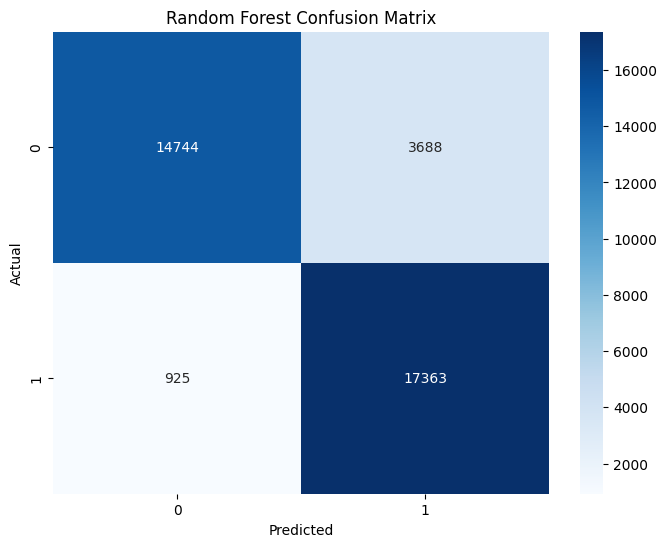

In [ ]:
# Confusion matrix
conf_matrix_RF = confusion_matrix(y_test, y_pred_RF)
plot_confusion_matrix(conf_matrix_RF, 'Random Forest Confusion Matrix')

### **CNN**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)

# Build the Convolutional Neural Network (CNN)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer with one neuron for binary classification

# Compile the model with a custom learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Add EarlyStopping callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with more validation data
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.3, callbacks=[early_stopping])

# Predict and evaluate
y_pred_probs = model.predict(X_test_reshaped)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions
print("CNN Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN Confusion Matrix')
plt.show()

In [ ]:
# Plot training & validation loss and accuracy values in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot training & validation loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train Loss', 'Validation Loss'], loc='upper right')
ax1.set_xlim([1, len(history.history['loss'])])  # Set x-axis limit to start from 1

# Plot training & validation accuracy
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Model Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')
ax2.set_xlim([1, len(history.history['accuracy'])])  # Set x-axis limit to start from 1

plt.tight_layout()
plt.show()

NameError: name 'history' is not defined

<Figure size 1200x600 with 0 Axes>

### **save model**

In [ ]:
import joblib
model_path = 'xgb_model.pkl'
# Save the model to disk using joblib
joblib.dump(XGB_model, model_path)

print(f"XGBoost model saved successfully to {model_path}")

XGBoost model saved successfully to xgb_model.pkl


### **Naive Bayes**

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.57      0.66     18353
           1       0.10      0.98      0.18       296
           2       0.76      0.82      0.79     25849

    accuracy                           0.72     44498
   macro avg       0.54      0.79      0.54     44498
weighted avg       0.76      0.72      0.73     44498



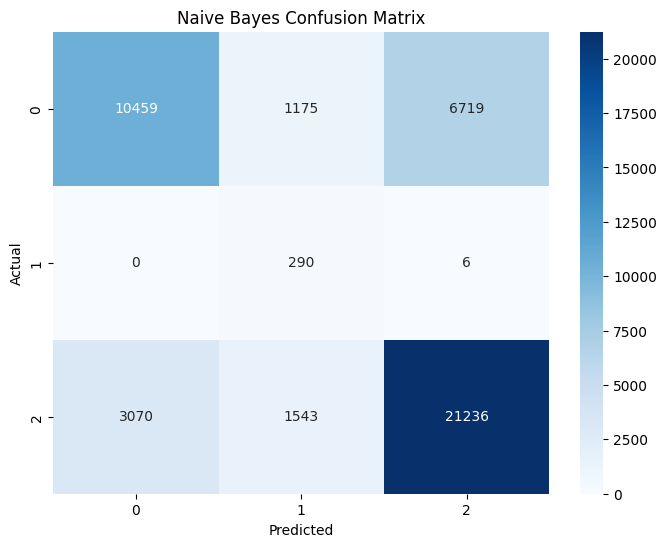

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_NB = NB_model.predict(X_test)
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_NB))

# Confusion matrix
conf_matrix_NB = confusion_matrix(y_test, y_pred_NB)
plot_confusion_matrix(conf_matrix_NB, 'Naive Bayes Confusion Matrix')


### **XGBoost**

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.85      0.90     18353
           1       0.97      0.91      0.94       296
           2       0.90      0.97      0.93     25849

    accuracy                           0.92     44498
   macro avg       0.94      0.91      0.92     44498
weighted avg       0.92      0.92      0.92     44498



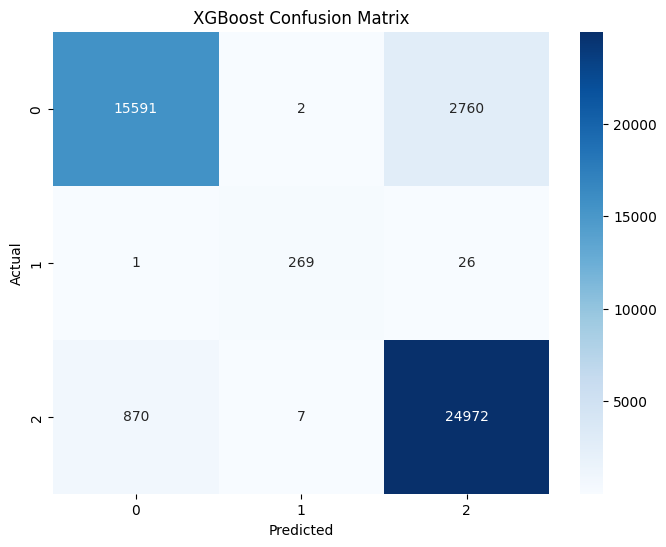

In [ ]:
import xgboost as xgb

# Train the model
XGB_model = xgb.XGBClassifier(random_state=42)
XGB_model.fit(X_train, y_train)
y_pred_XGB = XGB_model.predict(X_test)

conf_matrix_XGB = confusion_matrix(y_test, y_pred_XGB)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_XGB))

# Confusion matrix
conf_matrix_XGB = confusion_matrix(y_test, y_pred_XGB)
plot_confusion_matrix(conf_matrix_XGB, 'XGBoost Confusion Matrix')


### **MLPClassifier**

MLP Classifier Report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80     18353
           1       0.96      0.86      0.91       296
           2       0.84      0.91      0.87     25849

    accuracy                           0.85     44498
   macro avg       0.89      0.84      0.86     44498
weighted avg       0.85      0.85      0.84     44498



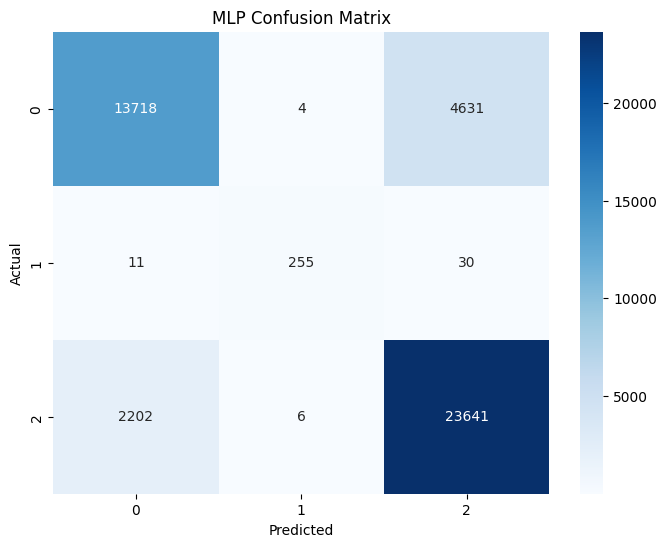

In [ ]:
from sklearn.neural_network import MLPClassifier

MLP_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
MLP_model.fit(X_train, y_train)
y_pred_MLP = MLP_model.predict(X_test)

# label_mapping = {1: 'Problem', 0: 'Incident', 2: 'Request'}
# y_test_mapped = y_test.map(label_mapping)
# y_pred_MLP_mapped = [label_mapping[label] for label in y_pred_MLP]
conf_matrix_MLP = confusion_matrix(y_test, y_pred_MLP)
print("MLP Classifier Report:\n", classification_report(y_test, y_pred_MLP))

# Confusion matrix
conf_matrix_MLP = confusion_matrix(y_test, y_pred_MLP)
plot_confusion_matrix(conf_matrix_MLP, 'MLP Confusion Matrix')

## **Compare**

In [ ]:
df['ticket_type'].value_counts()

ticket_type
Request     129146
Incident     91798
Problem       1545
Name: count, dtype: int64

In [ ]:
report_dict = {}
report_dict['Random Forest'] = classification_report(y_test, y_pred_RF, output_dict=True)
report_dict['Naive Bayes'] = classification_report(y_test, y_pred_NB, output_dict=True)
report_dict['XGBoost'] = classification_report(y_test, y_pred_XGB, output_dict=True)
report_dict['MLP Classifier'] = classification_report(y_test, y_pred_MLP, output_dict=True)

Metric          f1-score  precision    recall
Model                                        
MLP Classifier  0.843325   0.846788  0.845296
Naive Bayes     0.730280   0.760682  0.718796
Random Forest   0.887981   0.896533  0.890040
XGBoost         0.916850   0.919659  0.917614


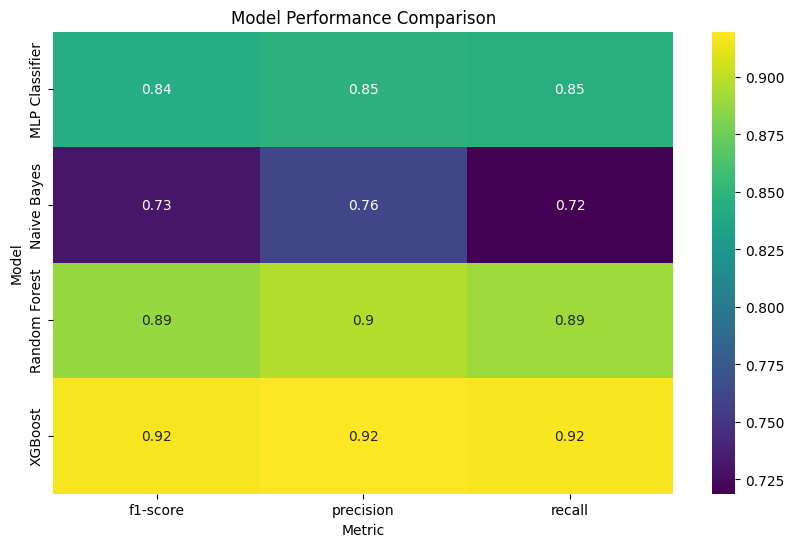

In [ ]:
# Extract relevant metrics and create a DataFrame
metrics = ['precision', 'recall', 'f1-score']
rows = []

for model_name, report in report_dict.items():
    for metric in metrics:
        avg_metric = report['weighted avg'][metric]
        rows.append({'Model': model_name, 'Metric': metric, 'Score': avg_metric})

performance_df = pd.DataFrame(rows)

# Pivot the DataFrame for better visualization
performance_pivot = performance_df.pivot(index='Model', columns='Metric', values='Score')
print(performance_pivot)

# Plot the performance table
plt.figure(figsize=(10, 6))
sns.heatmap(performance_pivot, annot=True, cmap='viridis')
plt.title('Model Performance Comparison')
plt.show()

## **BERT**
`bert-base-multilingual-cased`
### **Dataset Preparation**

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

In [ ]:
# Split the data into training and validation sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_df.shape, test_df.shape

((177991, 6), (44498, 6))

`Create PyTorch Dataset and DataLoader`


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TicketDataset(Dataset):
    def __init__(self, df):
        self.token_subject = df['token_subject'].tolist()
        self.token_description = df['token_description'].tolist()
        self.labels = df['label'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
            'input_ids_subject': torch.tensor(self.token_subject[idx], dtype=torch.long),
            'input_ids_description': torch.tensor(self.token_description[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

train_dataset = TicketDataset(train_df)
test_dataset = TicketDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


`use a pre-trained BERT model and adapt it for classification
`

In [ ]:
from transformers import BertModel, BertTokenizer, BertConfig, BertPreTrainedModel
import torch.nn as nn

class BertForTicketClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids_subject, input_ids_description, labels=None):
        # Combine subject and description
        input_ids_combined = torch.cat((input_ids_subject, input_ids_description), dim=1)

        outputs = self.bert(input_ids_combined)
        pooled_output = outputs[1]

        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return (loss, logits)

model_name = 'bert-base-multilingual-cased'
config = BertConfig.from_pretrained(model_name, num_labels=len(label_encoder.classes_))
model = BertForTicketClassification.from_pretrained(model_name, config=config)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTicketClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **Train**

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 2 #Epoch

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0

    for batch in data_loader:
        input_ids_subject = batch['input_ids_subject'].to(device)
        input_ids_description = batch['input_ids_description'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()

        loss, logits = model(input_ids_subject, input_ids_description, labels=labels)

        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

for epoch in range(2):  # Training for 3 epochs
    avg_train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
    print(f"Epoch {epoch+1}, Loss: {avg_train_loss}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### **Evaluate**

In [ ]:
from sklearn.metrics import classification_report

def evaluate(model, data_loader, device, label_encoder):
    model.eval()
    total_correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids_subject = batch['input_ids_subject'].to(device)
            input_ids_description = batch['input_ids_description'].to(device)
            labels = batch['labels'].to(device)

            loss, logits = model(input_ids_subject, input_ids_description, labels=labels)

            preds = torch.argmax(logits, dim=1)
            total_correct += torch.sum(preds == labels).item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = total_correct / len(data_loader.dataset)
    class_report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_, digits=4)
    return accuracy, class_report

# Assuming you have your label encoder already
accuracy, class_report = evaluate(model, test_loader, device, label_encoder)
print(f"Test Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)


### **save model**

In [ ]:
import torch
import os

# Directory to save the model
save_directory = 'models'
model_save_path = os.path.join(save_directory, 'best_model_state.bin')

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

In [ ]:
# Assuming you have already defined your model architecture and tokenizer
from transformers import BertForTicketClassification, BertConfig

# Load the model configuration
model_config = BertConfig.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

# Initialize the model
loaded_model = BertForTicketClassification.from_pretrained(model_name, config=model_config)

# Load the saved model state dictionary
loaded_model.load_state_dict(torch.load(model_save_path))

# Move model to the device (GPU if available)
loaded_model.to(device)

# Verify the loaded model (optional)
accuracy, class_report = evaluate(loaded_model, test_loader, device, label_encoder)
print(f"Loaded Model Test Accuracy: {accuracy}")
print("Loaded Model Classification Report:")
print(class_report)


In [ ]:
# problem = df[df['ticket_type']=='Problem']
# df = df.drop(problem.index, inplace=True)
# df.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
!pip install pandas sentencepiece transformers torch sklearn

In [ ]:
df['ticket_type'].value_counts()

TypeError: 'NoneType' object is not subscriptable

### **❓Problem**
`ตัดน่าจะดีกว่า`

In [ ]:
df['subject'].value_counts()

subject
jv platform  softway    express cloud   ต่ออายุ wt                                                                             2300
ลงทะเบียน computer                                                                                                             1255
ปัญหาอื่นๆ                                                                                                                     1245
jv platform  softway    express cloud   สมัครใหม่ wt                                                                            878
jv platform  softway    express cloud   ต่ออายุ we                                                                              788
                                                                                                                               ... 
edi siam corp  mnsp    รบกวนตรวจสอบ prtg เครื่อง prd_edi siam_fileshare_cents hbfo เนื่องจากข้อมูล system uptime กับ memory       1
close  op sec createlcom   รบกวนแจ้งขอเปิดสิทธ์ download vpn เพื่อใช

In [ ]:
df[df['subject']=='ลงทะเบียน computer']['ticket_type'].value_counts() # ยุบรวมเป็น Request
df.loc[(df['subject'] == 'ลงทะเบียน computer') & (df['ticket_type'] == 'Problem'), 'ticket_type'] = 'Request'
print(df[df['subject'] == 'ลงทะเบียน computer']['ticket_type'].value_counts())

ticket_type
Request    1255
Name: count, dtype: int64


In [ ]:
df[df['subject']=='ปัญหาอื่นๆ']['ticket_type'].value_counts() # description ส่วนใหญ่จะเป็นตรวจคอมประจำปี ยุบรวมเป็น Problem
df.loc[(df['subject'] == 'ปัญหาอื่นๆ') & (df['ticket_type'] == 'Request'), 'ticket_type'] = 'Problem'
print(df[df['subject']=='ปัญหาอื่นๆ']['ticket_type'].value_counts()) #มี incident อันคือ คอมโดนบล็อก

ticket_type
Problem     1244
Incident       1
Name: count, dtype: int64


In [ ]:
df[df['subject']=='ลงทะเบียนคอมพิวเตอร์']['ticket_type'].value_counts() # ยุบรวมเป็น Request
df.loc[(df['subject'] == 'ลงทะเบียนคอมพิวเตอร์') & (df['ticket_type'] == 'Problem'), 'ticket_type'] = 'Request'
print(df[df['subject'] == 'ลงทะเบียนคอมพิวเตอร์']['ticket_type'].value_counts())

ticket_type
Request    201
Name: count, dtype: int64


In [ ]:
df['ticket_type'].value_counts()

ticket_type
Request     129183
Incident     91798
Problem       1508
Name: count, dtype: int64

```
Class ‘Problem’
ถ้าดูจาก ‘Deacription’ ส่วนใหญ่จะเป็น ‘ตรวจสอบคอม’ ในขณะที่
ถ้าดูจาก ‘Subject’ จะเป็น ‘ปัญหาอื่นๆ’
และถ้าเราไปดู ‘subject’ == ‘ตรวจสอบคอม’ มันจะตกอยู่ในคลาส Request ทำให้คิดว่า

> ยุบคลาส Problem ที่ ‘Description’ มีคำว่าตรวจสอบคอม แปลงเป็นคำว่า 'ตรวจสอบคอมพิวเตอร์'
> ยุบรวม ไปอยู่ใน Request

```

In [ ]:
pattern = r"ตรวจ|ตรวจคอม|ตรวจสอบ|ตรวจสอบคอม|คอม"
problem_df = df[df['ticket_type'] == 'Problem']
contains_pattern = problem_df['description'].str.contains(pattern)
a = problem_df[contains_pattern]
a

,subject,description,ticket_type
3887,ปัญหาอื่นๆ,ตรวจคอมพิวเตอร์ประจำปี,Problem
7231,ปัญหาอื่นๆ,ตรวจสอบคอมพิวเตอร์,Problem
7366,ปัญหาอื่นๆ,ตรวจคอมพิวเตอร์ประจำปี,Problem
9269,ปัญหาอื่นๆ,ตรวจคอมพิวเตอร์ประจำปี รอบวันที่ มิ ย ธัญช...,Problem
13288,ปัญหาอื่นๆ,ตรวจสอบคอมพิวเตอร์,Problem
...,...,...,...
218088,ปัญหาอื่นๆ,ตรวจคอมพิวเตอร์ประจำปี,Problem
218109,ปัญหาอื่นๆ,ตรวจคอมพิวเตอร์ประจำปี,Problem
220459,ปัญหาอื่นๆ,ตรวจคอมพิวเตอร์ประจำปี,Problem
220719,ปัญหาอื่นๆ,ตรวจคอมพิวเตอร์ประจำปี,Problem


In [ ]:
# Function to replace words in description
def replace_words(description):
    return 'ตรวจสอบคอมพิวเตอร์'
def Request(ticket_type):
    return 'Request'
for index, row in a.iterrows():
    df.loc[index, 'description'] = replace_words(row['description'])
    df.loc[index, 'ticket_type'] = Request(row['ticket_type'])

In [ ]:
#df.loc[3887] #check

In [ ]:
df['ticket_type'].value_counts()

ticket_type
Request     130183
Incident     91798
Problem        508
Name: count, dtype: int64

```
ปัญหาที่เหลือจะเป็นเรื่องยิบย่อย พวกลืมรหัส / set up / เว็บล่ม ซึ่งมันไม่ตายตัว
> df.loc index 508 rows นี้ให้ 'subject' เป็นคำว่า 'ปัญหาอื่นๆ'
> df.loc index 508 rows นี้ให้ 'description' เป็นคำว่า 'แจ้งปัญหาการใช้งาน'

```

In [ ]:
b = df[df['ticket_type']=='Problem']
b

,subject,description,ticket_type
5754,nx cloud ลูกค้าแจ้งไม่สามารถใช้งาน vm ได้ จำ...,ลูกค้า nx cloud แจ้งไม่สามารถใช้งาน vm ได้ จำน...,Problem
5998,closed hp cloud เคสแม่ แจ้งปัญหาการใช้งาน...,art เรียนทีมครับ ขออนุญาตแจ้งเพื่อทราบครับ ปัจ...,Problem
15490,flexpod cloud แจ้งปัญหาการใช้งาน วันที่,เนื่องจากปัญหาผู้ใช้บริการไม่สามารถใช้งาน virt...,Problem
17325,one email เคสแม่ แจ้งปัญหาการใช้งาน zimbra...,one email เคสแม่ แจ้งปัญหาการใช้งาน zimbra...,Problem
17743,ปัญหาอื่นๆ,setup fa ศุภรดา ฤทัยรัตน์,Problem
...,...,...,...
204271,ปัญหาอื่นๆ,email แจ้งว่าไม่สามารถส่งข้อมูลได้เนื่องจากเกิ...,Problem
209083,inext broadband cgn cgn ทำงานผิดปกติ,case problem อ้างอิง ticket แจ้งปัญหาออกอินเต...,Problem
214868,ปัญหาอื่นๆ,scan virus,Problem
215812,ปัญหาอื่นๆ,รบกวนขอ license microsoftoffice,Problem


In [ ]:
# Function to replace words in description
def subject(subject):
    return 'ปัญหาอื่นๆ'
for index, row in b.iterrows():
    df.loc[index, 'subject'] = subject(row['subject'])

In [ ]:
pattern = r"แจ้ง|ปัญหา|ไม่|ไม่ได้|แจ้งปัญหา|set|เซ็ท|เซ็ต|เซท|ขอ|problem|รหัส|virus|ไวรัส|ใช้"
c = df[df['ticket_type'] == 'Problem']
c

,subject,description,ticket_type
5754,ปัญหาอื่นๆ,ลูกค้า nx cloud แจ้งไม่สามารถใช้งาน vm ได้ จำน...,Problem
5998,ปัญหาอื่นๆ,art เรียนทีมครับ ขออนุญาตแจ้งเพื่อทราบครับ ปัจ...,Problem
15490,ปัญหาอื่นๆ,เนื่องจากปัญหาผู้ใช้บริการไม่สามารถใช้งาน virt...,Problem
17325,ปัญหาอื่นๆ,one email เคสแม่ แจ้งปัญหาการใช้งาน zimbra...,Problem
17743,ปัญหาอื่นๆ,setup fa ศุภรดา ฤทัยรัตน์,Problem
...,...,...,...
204271,ปัญหาอื่นๆ,email แจ้งว่าไม่สามารถส่งข้อมูลได้เนื่องจากเกิ...,Problem
209083,ปัญหาอื่นๆ,case problem อ้างอิง ticket แจ้งปัญหาออกอินเต...,Problem
214868,ปัญหาอื่นๆ,scan virus,Problem
215812,ปัญหาอื่นๆ,รบกวนขอ license microsoftoffice,Problem


In [ ]:
# Function to replace words in description
def report(description):
    return 'แจ้งปัญหาการใช้งาน'
for index, row in c.iterrows():
    df.loc[index, 'description'] = report(row['description'])

In [ ]:
#df.loc[5754] #check

### **Request ⭕**

### **Incident❗**

In [ ]:
df['ticket_type'].value_counts()

ticket_type
Request     130183
Incident     91798
Problem        508
Name: count, dtype: int64

In [ ]:
df['subject'].value_counts()

subject
jv platform  softway    express cloud   ต่ออายุ wt                                      2300
ปัญหาอื่นๆ                                                                              1465
ลงทะเบียน computer                                                                      1255
jv platform  softway    express cloud   สมัครใหม่ wt                                     878
jv platform  softway    express cloud   ต่ออายุ we                                       788
                                                                                        ... 
close  op sec createlcom   รบกวนแจ้งขอเปิดสิทธ์ download vpn เพื่อใช้งานจำนวน  user        1
transformyou   ไม่สามารถ connect ไปหา backup repository ของ baclup multiplatform dom       1
jv platform  oneid    คุณเอมลออ พลอินทร์ แจ้ง e kyc                                        1
jenkongklai  sale    รบกวนตรวจสอบการใช้งาน service inext                                   1
kpmg phoomchai  mnsp    แจ้งรบกวนดำเนินการ disable limits swap

In [ ]:
df

,subject,description,ticket_type
0,interlink ma วันที่ กรกฎาคม เวลา น ...,from to cc sent monday july pm subjec...,Request
1,closed promessy corporation แจ้งตรวจสอบเครื่...,from werachat nawaroongruang to inet network...,Request
2,baac รบกวนเข้าไปเก็บตัวกล่องสัญญาณที่สาขาสาร...,รับสายลูกค้าคุณสุริยา เบอร์ แจ้งมีตัวกล่องอุป...,Request
3,transform you แจ้งขอข้อมูล lun ดังนี้ offsit...,from to cc sent thursday september am...,Request
4,gsb sd แบบคำขอเปลี่ยนแปลงทรัพยากรบน gsb clo...,from servicedesk to network operation cc at...,Request
...,...,...,...
222484,inet internal soc แจ้งตรวจสอบพบ crowdstrik...,from to cc sent jun am subject aut...,Incident
222485,control a solutions แจ้งขอข้อมูล ชื่อ vm และ...,from nantida vorasutipaibul to inet network ...,Request
222486,tcm mnsp รบกวนตรวจสอบเครื่อง veeam ที่ได้ม...,from siriporn tanasin to inet network operat...,Request
222487,closed op sec thevirus information and techno...,from kunanon ruanlek to inet network operati...,Request


## **Data Info**

### **numerical columns**

`numerical_columns=['impact', 'urgency', 'priority', 'ticket_type']`

```
use mapping value
```



In [ ]:
df['ticket_type'].value_counts()

ticket_type
Request     129146
Incident     91798
Problem       1545
Name: count, dtype: int64

In [ ]:
im_ur_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['impact'] = df['impact'].map(im_ur_mapping)
df['urgency'] = df['urgency'].map(im_ur_mapping)

In [ ]:
prior_mapping = {'P1': 1, 'P2': 2, 'P3': 3, 'P4': 4, 'P5':5}
df['priority'] = df['priority'].map(prior_mapping)

In [ ]:
label_mapping = {'Request': 0, 'Incident': 1, 'Problem': 2}
df['ticket_type'] = df['ticket_type'].map(label_mapping)

In [ ]:
check = df[['impact', 'urgency', 'priority', 'ticket_type']]
check.head(5)

,impact,urgency,priority,ticket_type
0,1,0,4,0
1,1,0,4,0
2,1,0,4,0
3,0,1,4,0
4,0,1,4,0


In [ ]:
# Calculate the correlation matrix
correlation_matrix = check.corr()

# Extract the correlation of 'ticket_type' with other columns
ticket_type_correlation = correlation_matrix['ticket_type']

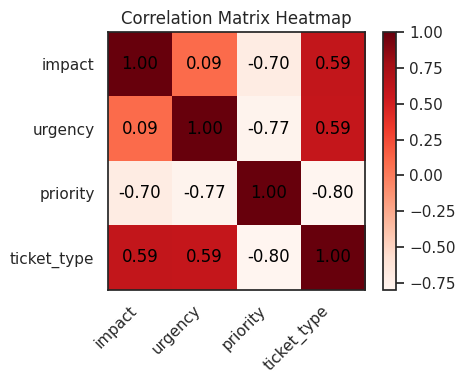

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 4))
heatmap = plt.imshow(correlation_matrix, cmap='Reds', interpolation='nearest')
plt.colorbar(heatmap)

# Add the column and row names
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(correlation_matrix.index)), correlation_matrix.index)

# Add annotations
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        plt.text(i, j, f'{correlation_matrix.iloc[j, i]:.2f}',
                 ha='center', va='center', color='black')

plt.title('Correlation Matrix Heatmap')
plt.tight_layout()

# Show the plot
plt.show()

### **features importance**

In [ ]:
# Function to convert to categorical codes while handling NaNs
def convert_to_codes_with_nan_handling(column):
    # Convert to category
    column_cat = column.astype('category')
    # Extract codes and handle NaNs
    codes = column_cat.cat.codes
    # Reassign NaNs in the original column
    codes[column.isna()] = np.nan
    return codes

# Apply the function to relevant columns
df['group'] = convert_to_codes_with_nan_handling(df['group'])
df['service'] = convert_to_codes_with_nan_handling(df['service'])
df['channel_notification'] = convert_to_codes_with_nan_handling(df['channel_notification'])
df['category'] = convert_to_codes_with_nan_handling(df['category'])

In [ ]:
set(data['group'])

{'BCP',
 'Back Office',
 'Barrel of Excellence (B.O.E.)',
 'CO-CSIRT',
 'CSIRT',
 'Chat Bot',
 'Chat Me',
 'Cloud Infra Migration',
 'D Solution Dot Com',
 'D-Solution Dot Com',
 'Dell-Cloud',
 'Digital Health Informatics (DHI)',
 'Digital Workflow',
 'EDC Pool',
 'Education Platform (EDU)',
 'Flexpod-Cloud',
 'HP-Cloud',
 'Healthcare',
 'INET-IDC1',
 'INET-IDC2',
 'INET-IDC3',
 'INET-MS',
 'INET-VDI',
 'Inext Broadband',
 'Infra-Cloud',
 'Infra-Network',
 'Infra-Virtual Firewall',
 'Internal Service',
 'Internet of Thing (IoT)',
 'Local Life Platform',
 'Local Life-Ecommerce',
 'Local Life-Food',
 'MNSP',
 'MOPH - หมอพร้อม (ใหญ่)',
 'MS-Cloud',
 'Manage AI',
 'Mandala KhonKaen',
 'Mobilyst',
 'My Platform',
 'NOC',
 'NOCKKC',
 'Network',
 'Network-Security',
 'Nex Gen Shop (NGS)',
 'Nutanix-Cloud',
 'OLS-Container',
 'One Authen',
 'One Centric',
 'One Conference',
 'One Electronic Billing',
 'One ID',
 'One Portal',
 'One Space',
 'One-Email',
 'One-Email [Exchange Mail]',
 'Openland

In [ ]:
df[df['group'].isnull()]['channel_notification'].value_counts()

channel_notification
336.0    30
563.0    22
564.0    16
337.0    12
339.0     9
364.0     8
351.0     2
47.0      1
548.0     1
Name: count, dtype: int64

In [ ]:
df[df['channel_notification'] == 336]['ticket_type']

ticket_type
1    70
Name: count, dtype: int64

In [ ]:
df[(df['channel_notification'] == 336) & (df['group'].isnull())] # ==> fill group with 39

,ticket_no,subject,description,impact,urgency,priority,ticket_type,group,service,channel_notification,category,sub_category,created_at
8499,220825355,JV-One Box : NOC ได้รับ Alert VM : Application...,From: onebox@inet.co.th\nTo: onebox@inet.co.th...,1,1,3,1,NaN,NaN,336.0,NaN,NaN,2022-08-25 17:02:05.015914+00
12157,22072890,JV-One Box : NOC ได้รับ Alert [CN0-000353][JV-...,From: onebox@inet.co.th\nTo: onebox@inet.co.th...,2,1,2,1,NaN,NaN,336.0,NaN,NaN,2022-07-28 20:37:40.811843+00
24238,220929279,One-Box : NOC ได้รับ Alert [JV-One Box] Serv...,\n\nFrom: onebox@inet.co.th\nTo: onebox@inet.c...,1,1,3,1,NaN,NaN,336.0,NaN,NaN,2022-09-29 17:14:32.599223+00
32541,220506209,One Centric (E-Tax Project :Onebox) : NOC ได้ร...,"From: ""INET_Flexpod Cloud Monitor"" <INET_Flexp...",1,1,3,1,NaN,NaN,336.0,NaN,NaN,2022-05-06 09:09:50.048674+00
35570,220429210,JV-One Box : NOC ได้รับ Alert VM Name : Applic...,\n\nFrom: onebox@inet.co.th\nTo: onebox@inet.c...,2,2,1,1,NaN,NaN,336.0,NaN,NaN,2022-04-29 09:09:29.012849+00
35641,220427268,JV-One Box : NOC ได้รับ Alert VM : pplication ...,\n\nFrom: onebox@inet.co.th\nTo: onebox@inet.c...,2,2,1,1,NaN,NaN,336.0,NaN,NaN,2022-04-27 11:23:22.070395+00
35879,220503139,JV-One Box : NOC ได้รับ Alert VM Name : Applic...,From: onebox@inet.co.th\nTo: onebox@inet.co.th...,1,1,3,1,NaN,NaN,336.0,NaN,NaN,2022-05-03 06:41:51.644761+00
35950,220530642,JV-One Box : noc ได้รับ Alert [JV-One Box] Ser...,From: onebox@inet.co.th\nTo: onebox@inet.co.th...,2,1,2,1,NaN,NaN,336.0,NaN,NaN,2022-05-30 18:08:29.722404+00
35969,22042842,JV-One Box : NOC ได้รับ Alert VM Name : Applic...,From: onebox@inet.co.th\nTo: onebox@inet.co.th...,2,2,1,1,NaN,NaN,336.0,NaN,NaN,2022-04-28 02:56:01.83574+00
35973,22042843,JV-One Box : NOC ได้รับ Alert VM Name : Applic...,From: onebox@inet.co.th\nTo: onebox@inet.co.th...,1,1,3,1,NaN,NaN,336.0,NaN,NaN,2022-04-28 02:57:21.604094+00


In [ ]:
prob = df[]

array(['From: "NQM Interlink Telecom" <nqm@interlinktelecom.co.th>\nTo: "INET Network Operation" <noc@inet.co.th>, "op-bb" <op-bb@inet.co.th>, inext-service@inet.co.th\nCc: planwork@interlinktelecom.co.th, "k chariya" <k.chariya@interlinktelecom.co.th>\nSent: Monday, July 11, 2022 4:06:20 PM\nSubject: !!! Urgent !!! : ขอจัดส่งจดหมายแจ้งกำหนดการปรับปรุงบริการวงจร  จำนวน 10 วงจร รายละเอียดตามจดหมายแจ้งเลขที่ NQM/2022-849-023\n\n \n\n \n\n \n\n \n\nเรื่อง        ขอแจ้งกำหนดการปรับปรุงการให้บริการ \n\n \n\nเรียน       บริษัท ไอเน็กซ์ บรอดแบนด์ จำกัด\n\n\nขอจัดส่งจดหมายแจ้งปรับปรุงการบริการวงจร      จำนวน 10 วงจร\n\nวัตถุประสงค์การดำเนินการ              :   ปรับปรุงบริการโครงข่าย เนื่องจากจะดำเนินการ Replace อุปกรณ์ภายใน Node\n\nพื้นที่ดำเนินการ                                 :    Node บุรีรัมย์ Site Interlink\n\nวัน เริ่มดำเนินการ                              :   วันที่ 15 กรกฎาคม 2565  เวลา 00.00 น. (คืนวันพฤหัสบดีที่ 14 กรกฎาคม 2565)\n\nวัน สิ้นสุดดำเนินการ                         :   ว

In [ ]:
df.isnull().sum()

ticket_no                    0
subject                      0
description                 80
impact                       0
urgency                      0
priority                     0
ticket_type                  0
group                      297
service                  12447
channel_notification     12489
category                 56914
sub_category            206416
created_at                   0
dtype: int64

In [ ]:
df[df['group'].isnull()]['subject'].value_counts()

subject
ลงทะเบียน Computer                                                                                                                                              5
แจ้งเคส 10741 โรงพยาบาลวชิระภูเก็ต                                                                                                                              2
แจ้งเคส 11874 โรงพยาบาลสิริเวช จันทบุรี                                                                                                                         2
[JV-Platform][One Box] : ขอข้อมูลใบเสร็จ เดอะมอลล์กรุ๊ป                                                                                                         1
[JV] ManageAI : Noc ได้รับ Alert VM : [ManageAI-Checkup-Node-06-POC] [IP:(10.100.101.26)] มีการใช้งาน Memory = 90% เมื่อ Saturday, June 11, 2022 10:40:49 AM    1
                                                                                                                                                               ..
[JV-Platform][One Bo